# Import libraries

In [15]:
import jax
import numpy as np
import ximinf.nn_inference as nninf
import ximinf.nn_test as nnte
# import ximinf.generate_sim as gsim
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Set device type

In [2]:
jax.devices()
cpu = jax.devices("cpu")[0]
gpu = jax.devices("METAL")[0]

key = jax.random.PRNGKey(42)

W0000 00:00:1764687669.259378 1540139 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1764687669.310151 1540139 service.cc:145] XLA service 0x7fce0a288ef0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764687669.310177 1540139 service.cc:153]   StreamExecutor device (0): Metal, <undefined>


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 3.99 GB



I0000 00:00:1764687670.244570 1540139 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1764687670.244642 1540139 mps_client.cc:384] XLA backend will use up to 8572612608 bytes on device 0 for SimpleAllocator.


# Load data

In [3]:
columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 'prompt', 'localcolor', 'localcolor_err', 'z']
df = pd.read_parquet("../data/inference_data_frame.parquet")
# flat = gsim.flatten_df(df, columns)

# Load NN

In [4]:
# Parameters

model = nninf.load_nn('../data/NNs/nn_model')


NNX State restored: 


# MCMC

## Set priors

In [10]:
model.eval()

# ========== Global Settings ==========
BOUNDS = jnp.array([[-0.3, 0], [2.5, 3.5], [-20, -19], [0.05, 0.15]])

## Prepare input

In [ ]:
# Convert each column to a 1D array and concatenate into shape (M*C,)
# Prepare inference arrays
data_arrays = [jnp.asarray(df[col].to_numpy()) for col in columns]  # shape (N, M) for each column
data_concat_infer = jnp.concatenate(data_arrays, axis=-1)           # shape (N, M*n_cols)


mask_infer = jnp.ones_like(data_arrays[0])     

# Concatenate features + mask
inputs_infer = jnp.concatenate([data_concat_infer, mask_infer], axis=-1)


print(inputs_infer)




[18.620813 18.519905 16.733091 ...  1.        1.        1.      ]


## Launch MCMC

In [ ]:
with jax.default_device(cpu):
    def log_post(theta):
            return nnte.log_prob_fn(theta, model, inputs_infer, BOUNDS)

    # Initial position at the middle of the priors from bounds
    theta_init = (BOUNDS[:, 0] + BOUNDS[:, 1]) / 2.0

    print("Launch MCMC ...")
    # Run MCMC
    key, post = nnte.sample_posterior(
        log_post,
        n_warmup=1000,
        n_samples=2000,
        init_position = theta_init,
        rng_key=key
    )

print("...finished")


In [7]:
samples = post.at[:, 2].add(19.3)  # does not copy unnecessarily
samples_np = np.array(samples)     # only one device-to-host copy

In [8]:
print(samples_np)

[[-0.22635101  3.1773646  -0.690588    0.08134202]
 [-0.22569627  3.1701903  -0.69792175  0.08352596]
 [-0.22569627  3.1701903  -0.69792175  0.08352596]
 ...
 [-0.05774674  3.0017843   0.14649582  0.11741351]
 [-0.03852134  2.8843136   0.03466415  0.13826053]
 [-0.03074021  2.826719    0.27631187  0.12186769]]


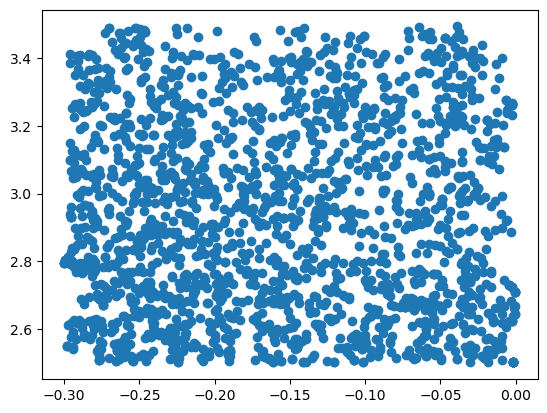

In [16]:
plt.scatter(samples_np[:,0], samples_np[:,1])
plt.show()

In [9]:
np.save("../data/results/sbi_posterior.npy", samples_np)